## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке.

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее.

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф.
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет.


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Прочитаем наш файл с исходными данными:

In [3]:
taxi_data = pd.read_csv("/content/drive/MyDrive/Taxi/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок.

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу.

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S').

Определите временные рамки (без учета времени), за которые представлены данные.

In [4]:
# Переводим столбец pickup_datetime в формат datetime
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

# Находим минимальную и максимальную дату
start_date = taxi_data['pickup_datetime'].min().date()
end_date = taxi_data['pickup_datetime'].max().date()

print(f'Временные рамки: с {start_date} по {end_date}')

Временные рамки: с 2016-01-01 по 2016-06-30


### Задание 2.2
Посмотрим на пропуски.
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [5]:
# Считаем пропущенные значения по каждому столбцу
missing_values = taxi_data.isnull().sum()

# Суммарное количество пропущенных значений по всем столбцам
total_missing = missing_values.sum()

print(f'Общее количество пропущенных значений: {total_missing}')

Общее количество пропущенных значений: 0


### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков.

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [6]:
# Количество уникальных таксопарков
unique_taxi_vendors = taxi_data['vendor_id'].nunique()
print(f'Количество уникальных таксопарков: {unique_taxi_vendors}')

Количество уникальных таксопарков: 2


In [7]:
# Максимальное количество пассажиров
max_passenger_count = taxi_data['passenger_count'].max()
print(f'Максимальное количество пассажиров: {max_passenger_count}')

Максимальное количество пассажиров: 9


In [8]:
# Средняя и медианная длительность поездки
mean_trip_duration = round(taxi_data['trip_duration'].mean())
median_trip_duration = round(taxi_data['trip_duration'].median())

print(f'Средняя длительность поездки: {mean_trip_duration} секунд')
print(f'Медианная длительность поездки: {median_trip_duration} секунд')

Средняя длительность поездки: 959 секунд
Медианная длительность поездки: 662 секунд


In [9]:
# Минимальное и максимальное время поездки
min_trip_duration = taxi_data['trip_duration'].min()
max_trip_duration = taxi_data['trip_duration'].max()

print(f'Минимальное время поездки: {min_trip_duration} секунд')
print(f'Максимальное время поездки: {max_trip_duration} секунд')

Минимальное время поездки: 1 секунд
Максимальное время поездки: 3526282 секунд


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками.


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [10]:
def add_datetime_features(df):
    # Добавление новых признаков
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek + 1  # Порядковый номер дня недели (с 1 для понед. по 7 для воскрес.)

    return df

# Применяем функцию к данным
taxi_data = add_datetime_features(taxi_data)

In [11]:
# Количество поездок, совершенных в субботу (день недели 6)
saturday_trips = taxi_data[taxi_data['pickup_day_of_week'] == 6].shape[0]
print(f'Количество поездок в субботу: {saturday_trips}')

Количество поездок в субботу: 220868


In [12]:
# Среднее количество поездок в день
average_trips_per_day = round(taxi_data.groupby('pickup_date').size().mean())
print(f'Среднее количество поездок в день: {average_trips_per_day}')

Среднее количество поездок в день: 8015


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет).

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [13]:
# Загрузка данных о праздниках
holiday_data = pd.read_csv('/content/drive/MyDrive/Taxi/holiday_data.csv', sep=';')

# Посмотрим на данные о праздниках
print(holiday_data.head())

# Определяем функцию для добавления признака праздничных дней
def add_holiday_features(df, holiday_df):
    # Преобразуем столбцы с датами в формат datetime, если еще не преобразованы
    holiday_df['holiday_date'] = pd.to_datetime(holiday_df['date']).dt.date
    df['pickup_date'] = pd.to_datetime(df['pickup_datetime']).dt.date

    # Добавляем бинарный признак для праздничных дней
    df['pickup_holiday'] = df['pickup_date'].isin(holiday_df['holiday_date']).astype(int)

    return df

# Загрузка данных о праздниках
holiday_data = pd.read_csv('/content/drive/MyDrive/Taxi/holiday_data.csv', sep=';')

# Применяем функцию для добавления признака holiday
taxi_data = add_holiday_features(taxi_data, holiday_data)

# Медианная длительность поездки на такси в праздничные дни
median_trip_duration_holiday = round(taxi_data[taxi_data['pickup_holiday'] == 1]['trip_duration'].median())

print(f'Медианная длительность поездки в праздничные дни: {median_trip_duration_holiday} секунд')

      day        date                     holiday
0  Friday  2016-01-01               New Years Day
1  Monday  2016-01-18  Martin Luther King Jr. Day
2  Friday  2016-02-12          Lincoln's Birthday
3  Monday  2016-02-15             Presidents' Day
4  Sunday  2016-05-08                Mother's Day
Медианная длительность поездки в праздничные дни: 585 секунд


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM?

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника.

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [14]:
osrm_data = pd.read_csv('/content/drive/MyDrive/Taxi/osrm_data_train.csv')

In [15]:
# Функция для добавления признаков из OSRM в данные о поездках
def add_osrm_features(df, osrm_df):
    # Объединяем данные о поездках с данными из OSRM по ключу 'id'
    merged_df = df.merge(osrm_df[['id', 'total_distance', 'total_travel_time', 'number_of_steps']], on='id', how='left')

    # Рассчитываем разницу в медианной длительности поездки в данных и в данных из OSRM
    median_trip_duration_data = round(df['trip_duration'].median())  # Медиана из данных о поездках
    median_trip_duration_osrm = round(merged_df['total_travel_time'].median())  # Медиана из данных OSRM

    trip_duration_difference = median_trip_duration_data - median_trip_duration_osrm
    print(f'Разница в медианной длительности поездки: {trip_duration_difference} секунд')

    # Считаем количество пропусков в столбцах с информацией из OSRM
    missing_osrm_data = merged_df[['total_distance', 'total_travel_time', 'number_of_steps']].isnull().sum().sum()
    print(f'Количество пропусков в данных из OSRM: {missing_osrm_data}')

    return merged_df

# Применяем функцию к данным о поездках и OSRM
taxi_data = add_osrm_features(taxi_data, osrm_data)

Разница в медианной длительности поездки: 372 секунд
Количество пропусков в данных из OSRM: 3


### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [16]:
# Функция для расчета расстояния Хаверсина
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

# Функция для расчета направления (угла)
def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

# Функция для добавления географических признаков
def add_geographical_features(df):
    # Применяем функцию get_haversine_distance для расчета расстояния Хаверсина
    df['haversine_distance'] = df.apply(
        lambda row: get_haversine_distance(
            row['pickup_latitude'], row['pickup_longitude'],
            row['dropoff_latitude'], row['dropoff_longitude']
        ), axis=1
    )

    # Применяем функцию get_angle_direction для расчета направления
    df['direction'] = df.apply(
        lambda row: get_angle_direction(
            row['pickup_latitude'], row['pickup_longitude'],
            row['dropoff_latitude'], row['dropoff_longitude']
        ), axis=1
    )

    return df

# Применяем функцию к данным
taxi_data = add_geographical_features(taxi_data)

# Медианное расстояние Хаверсина (в километрах)
median_haversine_distance = round(taxi_data['haversine_distance'].median(), 2)

# Печатаем медианное расстояние
print(f'Медианное расстояние Хаверсина: {median_haversine_distance} км')

Медианное расстояние Хаверсина: 2.09 км


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [17]:
# Функция для добавления признака географического кластера
def add_cluster_features(df, kmeans_model):
    # Получаем предсказания кластеров для каждой поездки
    df['geo_cluster'] = kmeans_model.predict(
        np.hstack((df[['pickup_latitude', 'pickup_longitude']],
                   df[['dropoff_latitude', 'dropoff_longitude']]))
    )

    return df

# Создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))

# Обучаем алгоритм кластеризации (KMeans)
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

# Применяем функцию для добавления признака geo_cluster
taxi_data = add_cluster_features(taxi_data, kmeans)

# Считаем количество поездок в каждом кластере
cluster_sizes = taxi_data['geo_cluster'].value_counts()

# Наименьший кластер
smallest_cluster_size = cluster_sizes.min()

print(f'Количество поездок в наименьшем географическом кластере: {smallest_cluster_size}')

Количество поездок в наименьшем географическом кластере: 2


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки.

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [18]:
# Загрузка данных о погодных условиях
weather_data = pd.read_csv('/content/drive/MyDrive/Taxi/weather_data.csv')

# Функция для добавления погодных признаков
def add_weather_features(df, weather_df):
    # Преобразуем время в таблицах к одному формату для объединения
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']).dt.floor('H')
    weather_df['time'] = pd.to_datetime(weather_df['time']).dt.floor('H')  # Используем столбец 'time'

    # Объединяем данные о поездках с данными о погоде по времени
    merged_df = df.merge(weather_df[['time', 'temperature', 'visibility', 'wind speed', 'precip', 'events']],
                         left_on='pickup_datetime', right_on='time', how='left')

    return merged_df

# Применяем функцию для добавления погодных признаков
taxi_data = add_weather_features(taxi_data, weather_data)

# а) Сколько поездок было совершено в снежную погоду?
snowy_weather_trips = taxi_data[taxi_data['events'].str.contains('snow', case=False, na=False)].shape[0]
print(f'Количество поездок в снежную погоду: {snowy_weather_trips}')

# б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями?
missing_weather_data = taxi_data[['temperature', 'visibility', 'wind speed', 'precip', 'events']].isnull().sum().sum()
total_data_points = taxi_data.shape[0] * 5  # Умножаем на 5, так как 5 погодных столбцов
missing_weather_percentage = (missing_weather_data / total_data_points) * 100
print(f'Процент пропусков в столбцах с погодными условиями: {missing_weather_percentage:.2f}%')

<ipython-input-18-2d799bae4c9e>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']).dt.floor('H')
<ipython-input-18-2d799bae4c9e>:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_df['time'] = pd.to_datetime(weather_df['time']).dt.floor('H')  # Используем столбец 'time'


Количество поездок в снежную погоду: 13126
Процент пропусков в столбцах с погодными условиями: 19.68%


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски.
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана).

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам.

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [19]:
# Функция для заполнения пропусков в данных
def fill_null_weather_data(df):
    # Заполнение пропусков в погодных столбцах: temperature, visibility, wind speed, precip
    weather_columns = ['temperature', 'visibility', 'wind speed', 'precip']

    for column in weather_columns:
        df[column] = df.groupby('pickup_date')[column].transform(lambda x: x.fillna(x.median()))

    # Заполнение пропусков в столбце events
    df['events'] = df['events'].fillna('None')

    # Заполнение пропусков в столбцах данных OSRM: total_distance, total_travel_time, number_of_steps
    osrm_columns = ['total_distance', 'total_travel_time', 'number_of_steps']

    for column in osrm_columns:
        df[column] = df[column].fillna(df[column].median())

    return df

# Применяем функцию для заполнения пропусков
taxi_data = fill_null_weather_data(taxi_data)

# Медиана в столбце temperature после заполнения пропусков
median_temperature = round(taxi_data['temperature'].median(), 1)

# Выводим медиану
print(f'Медиана температуры после заполнения пропусков: {median_temperature}°C')

Медиана температуры после заполнения пропусков: 11.1°C


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки.

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа.

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды.
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом:
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


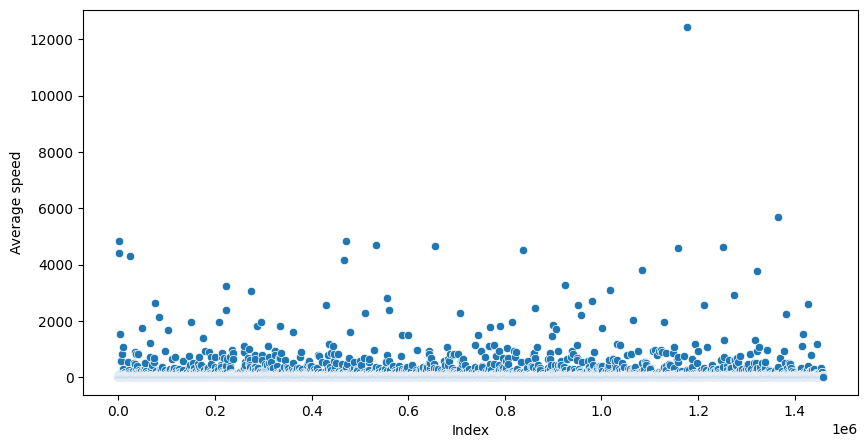

In [20]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч!

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч.


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных.

б) Сколько выбросов по признаку скорости вам удалось найти?

In [21]:
# Задаем пороговые значения
TIME_THRESHOLD = 24 * 60 * 60  # 24 часа в секундах
SPEED_THRESHOLD = 300  # 300 км/ч

# Находим поездки, длительность которых превышает 24 часа
outliers_duration = taxi_data[taxi_data['trip_duration'] > TIME_THRESHOLD]

# Удаляем эти строки
taxi_data_cleaned_duration = taxi_data[taxi_data['trip_duration'] <= TIME_THRESHOLD]

# Считаем количество выбросов по длительности поездки
num_outliers_duration = outliers_duration.shape[0]
print(f'Количество выбросов по длительности поездки: {num_outliers_duration}')

# Теперь находим поездки с высокой средней скоростью (выше 300 км/ч)
taxi_data_cleaned_duration['avg_speed'] = (taxi_data_cleaned_duration['total_distance'] / taxi_data_cleaned_duration['trip_duration']) * 3.6

# Находим выбросы по скорости (средняя скорость больше 300 км/ч)
outliers_speed = taxi_data_cleaned_duration[taxi_data_cleaned_duration['avg_speed'] > SPEED_THRESHOLD]

# Удаляем эти строки
taxi_data_cleaned_speed = taxi_data_cleaned_duration[taxi_data_cleaned_duration['avg_speed'] <= SPEED_THRESHOLD]

# Считаем количество выбросов по скорости
num_outliers_speed = outliers_speed.shape[0]
print(f'Количество выбросов по скорости: {num_outliers_speed}')

Количество выбросов по длительности поездки: 4


<ipython-input-21-d3130a2480a1>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_data_cleaned_duration['avg_speed'] = (taxi_data_cleaned_duration['total_distance'] / taxi_data_cleaned_duration['trip_duration']) * 3.6


Количество выбросов по скорости: 407


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных;
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [22]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log).
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным?
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$.

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

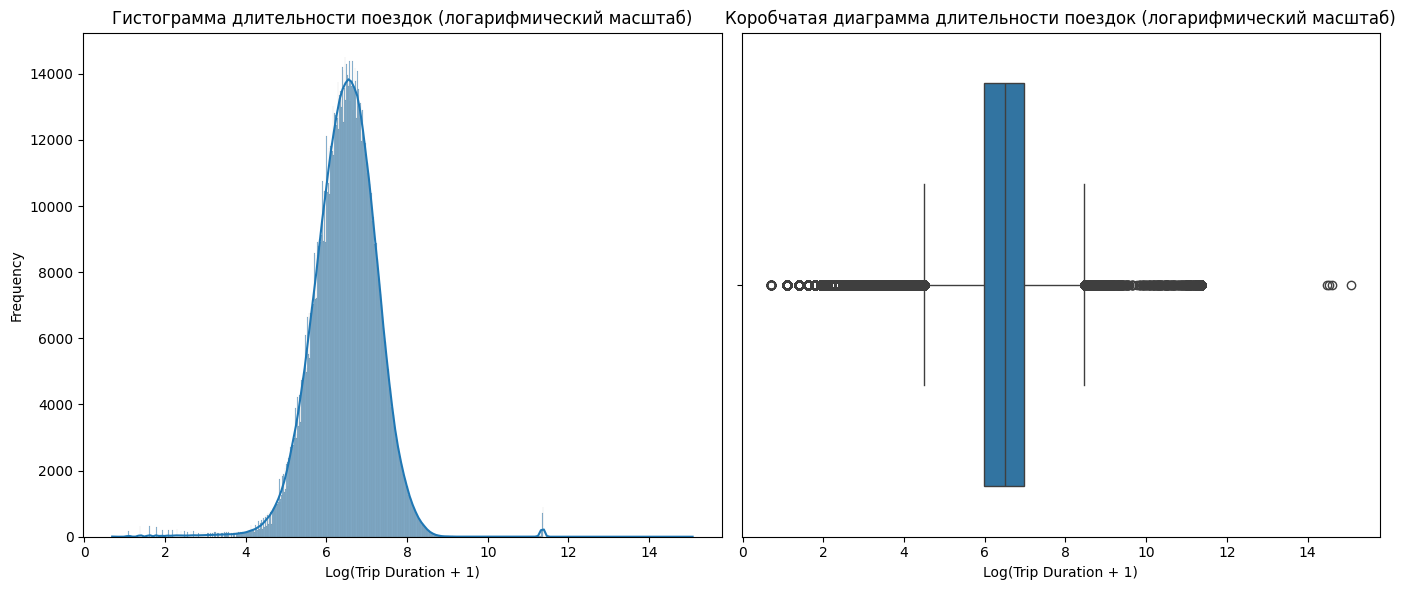

Вычисленный p-value: 0.00
Распределение не является нормальным (отклоняем нулевую гипотезу).


In [23]:
# Логарифмируем признак trip_duration
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration'] + 1)

# Построение гистограммы и коробчатой диаграммы
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Гистограмма
sns.histplot(taxi_data['trip_duration_log'], kde=True, ax=ax[0])
ax[0].set_title('Гистограмма длительности поездок (логарифмический масштаб)')
ax[0].set_xlabel('Log(Trip Duration + 1)')
ax[0].set_ylabel('Frequency')

# Коробчатая диаграмма
sns.boxplot(x=taxi_data['trip_duration_log'], ax=ax[1])
ax[1].set_title('Коробчатая диаграмма длительности поездок (логарифмический масштаб)')
ax[1].set_xlabel('Log(Trip Duration + 1)')

plt.tight_layout()
plt.show()

# Проведение теста Д'Агостино для проверки нормальности
stat, p_value = stats.normaltest(taxi_data['trip_duration_log'])

# Выводим p-value
print(f'Вычисленный p-value: {p_value:.2f}')

# Проверка гипотезы о нормальности
alpha = 0.05
if p_value < alpha:
    print("Распределение не является нормальным (отклоняем нулевую гипотезу).")
else:
    print("Распределение является нормальным (не отклоняем нулевую гипотезу).")

### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id).

Сравните два распределения между собой.

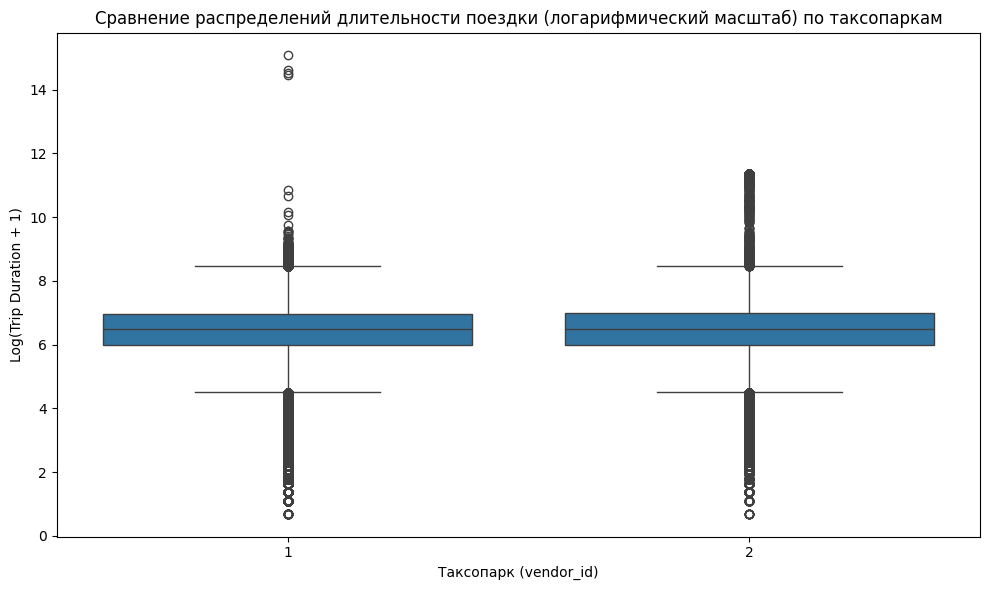

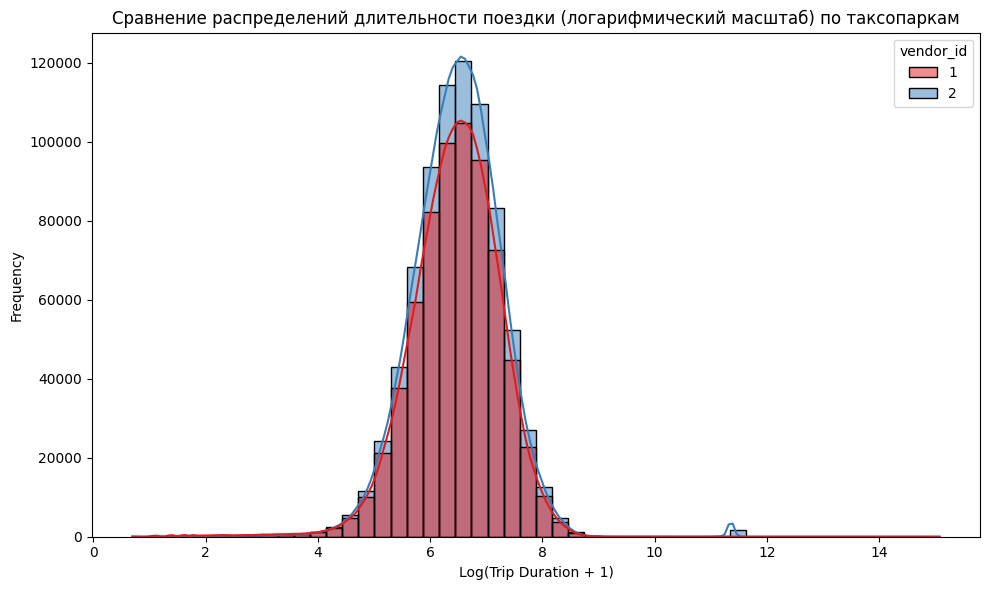

In [24]:
# Построение коробчатой диаграммы для сравнения распределений по таксопаркам
plt.figure(figsize=(10, 6))

# Коробчатая диаграмма для сравнения распределения длительности поездки по таксопаркам
sns.boxplot(x='vendor_id', y='trip_duration_log', data=taxi_data)
plt.title('Сравнение распределений длительности поездки (логарифмический масштаб) по таксопаркам')
plt.xlabel('Таксопарк (vendor_id)')
plt.ylabel('Log(Trip Duration + 1)')
plt.tight_layout()
plt.show()

# Альтернативно: Построение гистограммы с разделением по таксопаркам
plt.figure(figsize=(10, 6))

# Гистограмма для сравнения распределений длительности поездки
sns.histplot(data=taxi_data, x='trip_duration_log', hue='vendor_id', kde=True, bins=50, palette='Set1')
plt.title('Сравнение распределений длительности поездки (логарифмический масштаб) по таксопаркам')
plt.xlabel('Log(Trip Duration + 1)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag).

Сравните два распределения между собой.

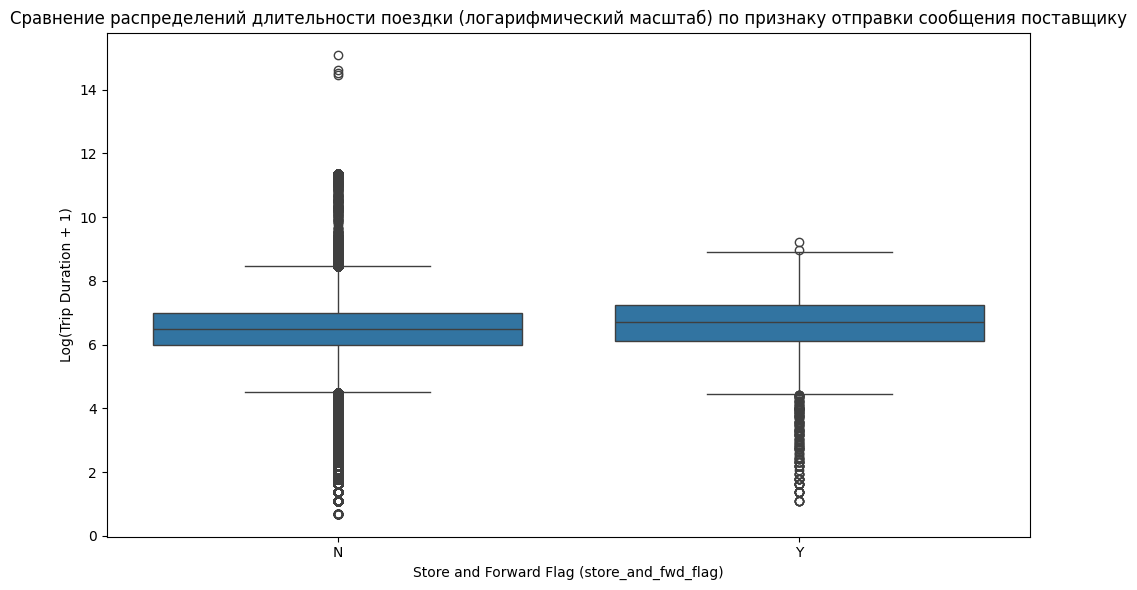

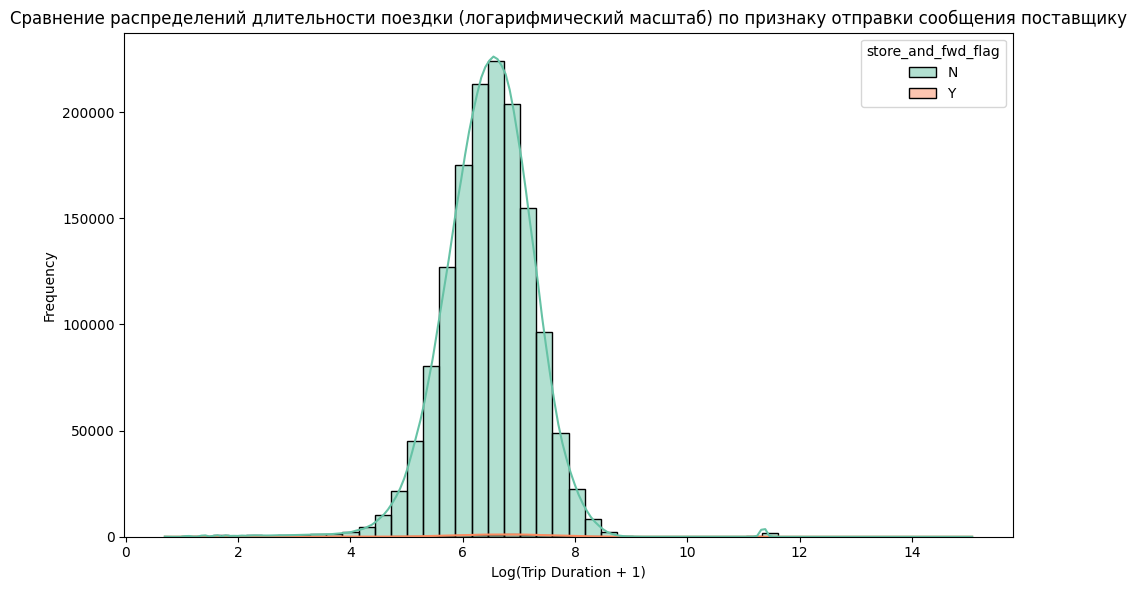

In [25]:
# Построение коробчатой диаграммы для сравнения распределений по признаку отправки сообщения поставщику
plt.figure(figsize=(10, 6))

# Коробчатая диаграмма для сравнения распределений длительности поездки в логарифмическом масштабе по признаку store_and_fwd_flag
sns.boxplot(x='store_and_fwd_flag', y='trip_duration_log', data=taxi_data)
plt.title('Сравнение распределений длительности поездки (логарифмический масштаб) по признаку отправки сообщения поставщику')
plt.xlabel('Store and Forward Flag (store_and_fwd_flag)')
plt.ylabel('Log(Trip Duration + 1)')
plt.tight_layout()
plt.show()

# Альтернативно: Построение гистограммы с разделением по признаку store_and_fwd_flag
plt.figure(figsize=(10, 6))

# Гистограмма для сравнения распределений длительности поездки
sns.histplot(data=taxi_data, x='trip_duration_log', hue='store_and_fwd_flag', kde=True, bins=50, palette='Set2')
plt.title('Сравнение распределений длительности поездки (логарифмический масштаб) по признаку отправки сообщения поставщику')
plt.xlabel('Log(Trip Duration + 1)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

<ipython-input-26-199775205fbe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='pickup_hour', data=taxi_data, palette='Set2')


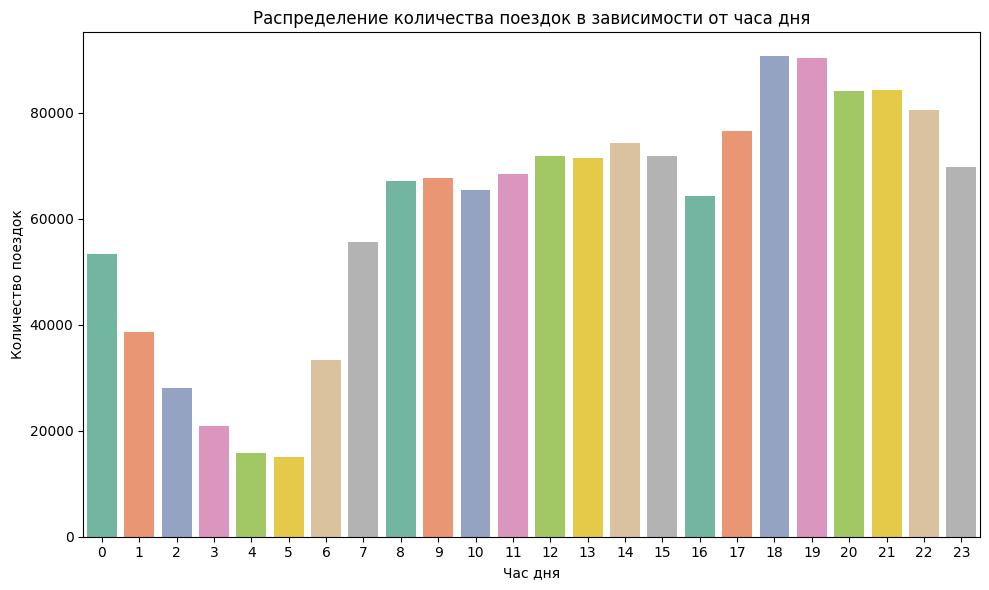

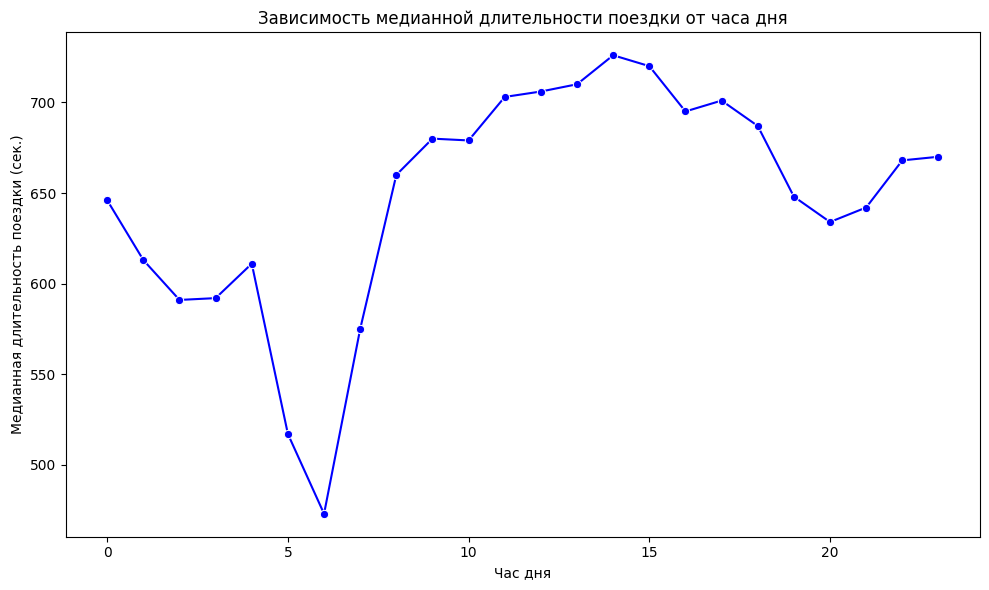

In [26]:
# Извлекаем час дня из столбца pickup_datetime
taxi_data['pickup_hour'] = taxi_data['pickup_datetime'].dt.hour

# 1. Распределение количества поездок в зависимости от часа дня
plt.figure(figsize=(10, 6))
sns.countplot(x='pickup_hour', data=taxi_data, palette='Set2')
plt.title('Распределение количества поездок в зависимости от часа дня')
plt.xlabel('Час дня')
plt.ylabel('Количество поездок')
plt.tight_layout()
plt.show()

# 2. Зависимость медианной длительности поездки от часа дня
median_trip_duration_by_hour = taxi_data.groupby('pickup_hour')['trip_duration'].median()

plt.figure(figsize=(10, 6))
sns.lineplot(x=median_trip_duration_by_hour.index, y=median_trip_duration_by_hour.values, marker='o', color='b')
plt.title('Зависимость медианной длительности поездки от часа дня')
plt.xlabel('Час дня')
plt.ylabel('Медианная длительность поездки (сек.)')
plt.tight_layout()
plt.show()

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


<ipython-input-27-890b1bf8d42b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='pickup_day_of_week', data=taxi_data, palette='Set2')


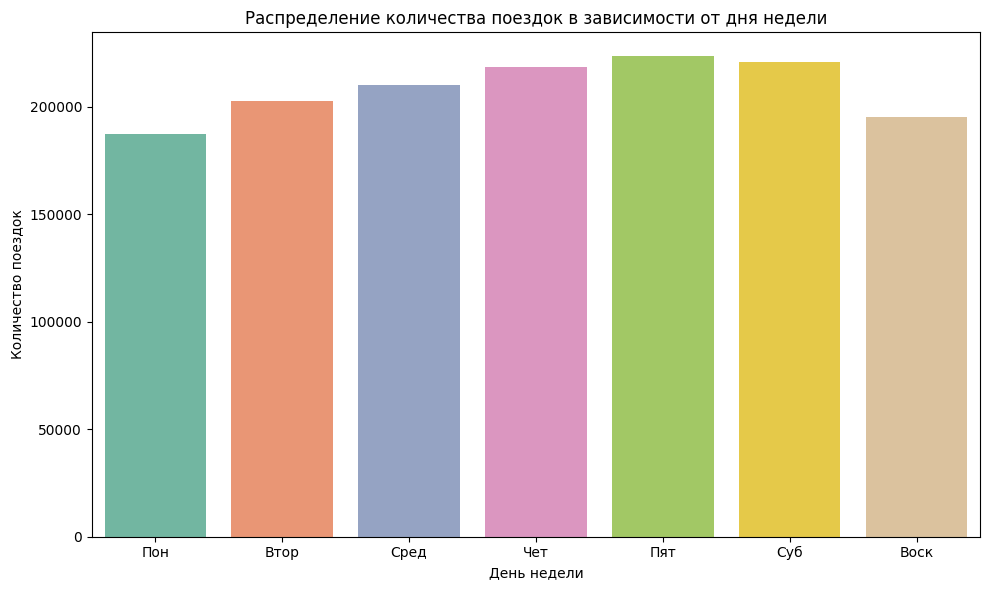

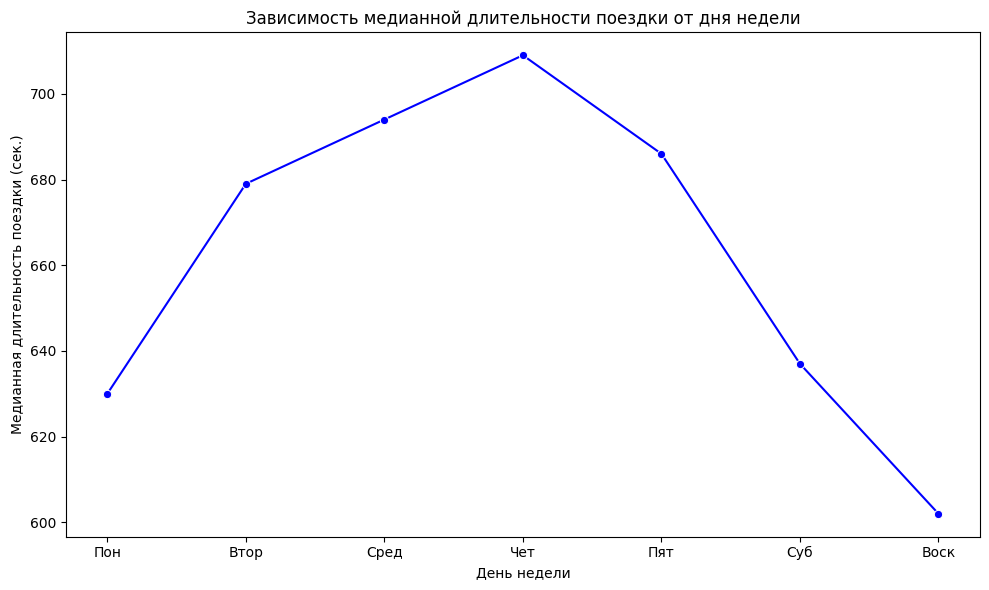

In [27]:
# Извлекаем день недели из столбца pickup_datetime
taxi_data['pickup_day_of_week'] = taxi_data['pickup_datetime'].dt.dayofweek

# 1. Распределение количества поездок в зависимости от дня недели
plt.figure(figsize=(10, 6))
sns.countplot(x='pickup_day_of_week', data=taxi_data, palette='Set2')
plt.title('Распределение количества поездок в зависимости от дня недели')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.xticks(ticks=range(7), labels=['Пон', 'Втор', 'Сред', 'Чет', 'Пят', 'Суб', 'Воск'])
plt.tight_layout()
plt.show()

# 2. Зависимость медианной длительности поездки от дня недели
median_trip_duration_by_day = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median()

plt.figure(figsize=(10, 6))
sns.lineplot(x=median_trip_duration_by_day.index, y=median_trip_duration_by_day.values, marker='o', color='b')
plt.title('Зависимость медианной длительности поездки от дня недели')
plt.xlabel('День недели')
plt.ylabel('Медианная длительность поездки (сек.)')
plt.xticks(ticks=range(7), labels=['Пон', 'Втор', 'Сред', 'Чет', 'Пят', 'Суб', 'Воск'])
plt.tight_layout()
plt.show()

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно.

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration).

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

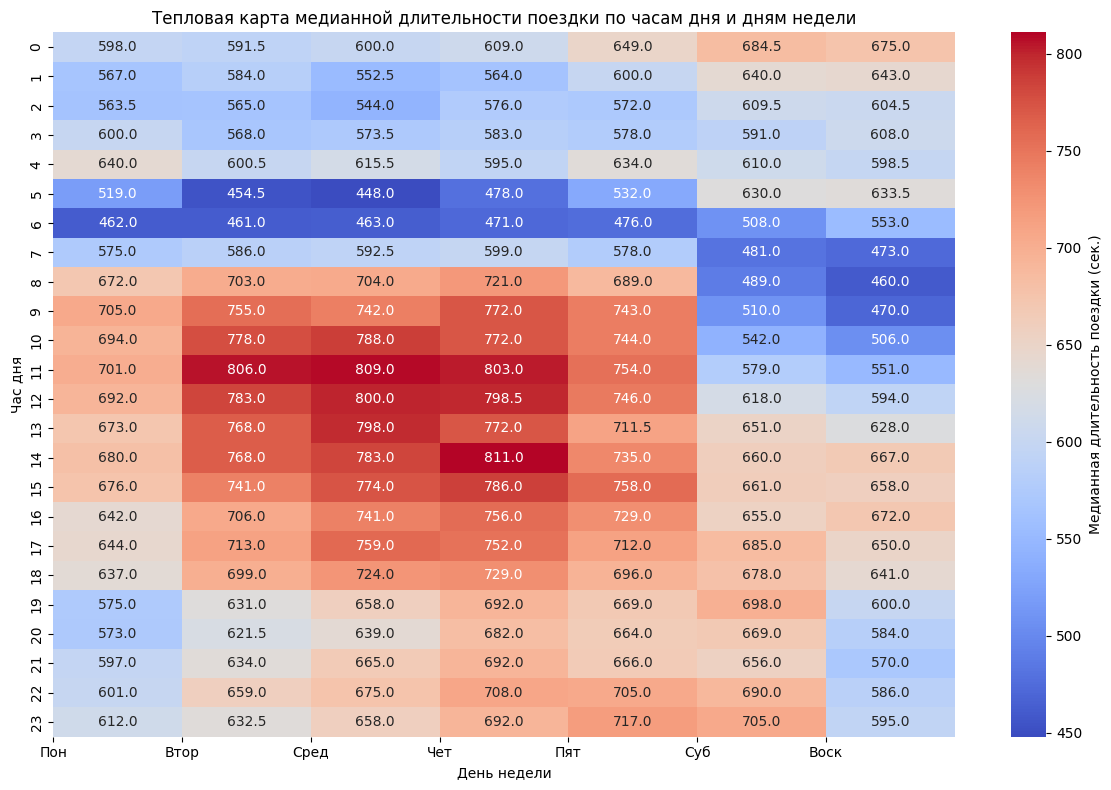

In [28]:
# Создаем сводную таблицу: по строкам - часы, по столбцам - дни недели, в ячейках - медианная длительность поездки
pivot_table = taxi_data.pivot_table(values='trip_duration',
                                   index='pickup_hour',
                                   columns='pickup_day_of_week',
                                   aggfunc='median')

# Визуализируем тепловую карту
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt='.1f', cbar_kws={'label': 'Медианная длительность поездки (сек.)'})
plt.title('Тепловая карта медианной длительности поездки по часам дня и дням недели')
plt.xlabel('День недели')
plt.ylabel('Час дня')
plt.xticks(ticks=range(7), labels=['Пон', 'Втор', 'Сред', 'Чет', 'Пят', 'Суб', 'Воск'])
plt.tight_layout()
plt.show()

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude)
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude).
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:

city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее.

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


<ipython-input-29-135e5eae4826>:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


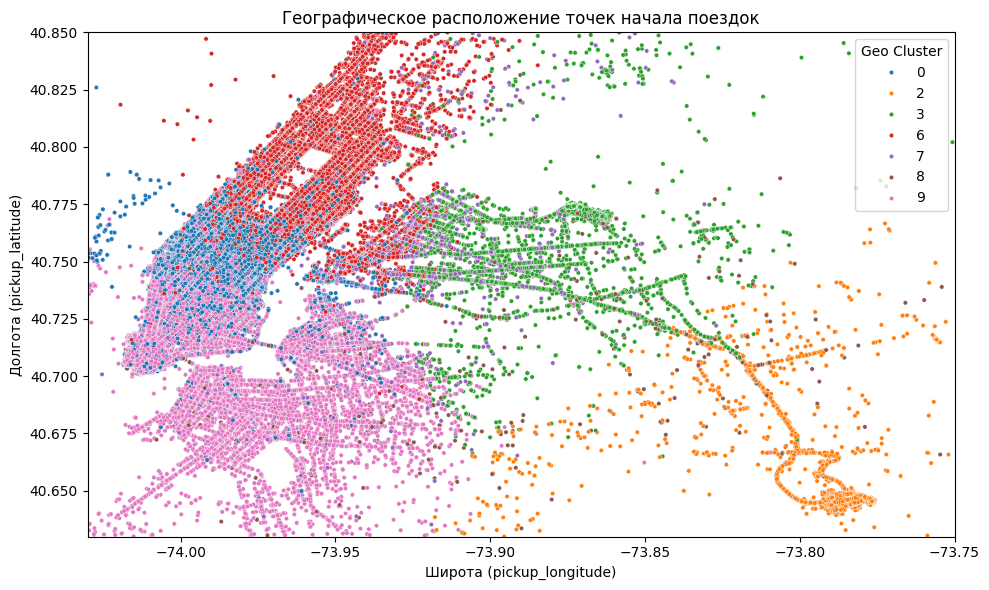

<ipython-input-29-135e5eae4826>:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


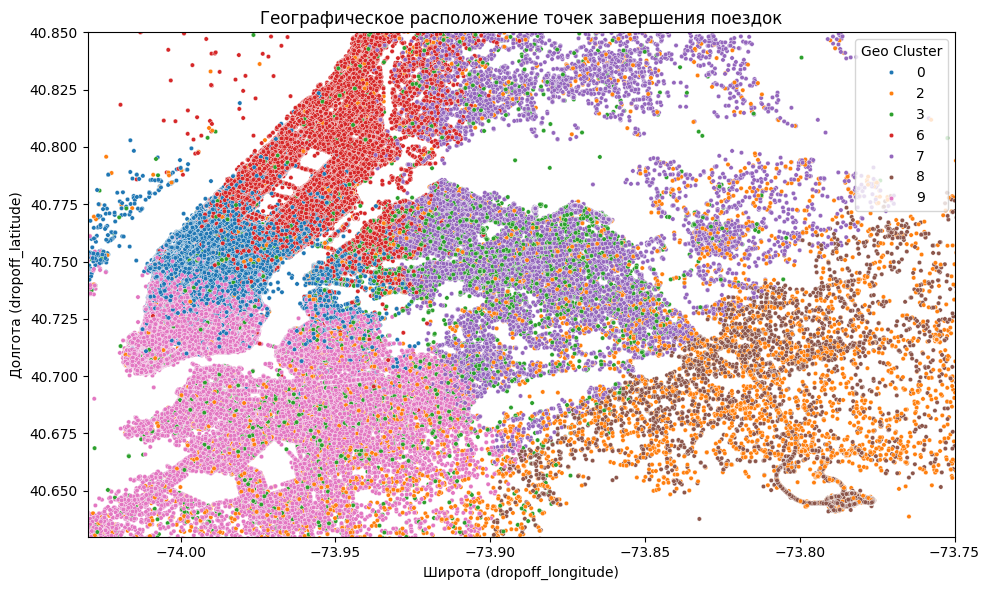

In [29]:
# Границы для Нью-Йорка
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Фильтруем данные, чтобы оставить только точки внутри Нью-Йорка
nyc_data = taxi_data[(taxi_data['pickup_longitude'] >= city_long_border[0]) &
                     (taxi_data['pickup_longitude'] <= city_long_border[1]) &
                     (taxi_data['pickup_latitude'] >= city_lat_border[0]) &
                     (taxi_data['pickup_latitude'] <= city_lat_border[1])]

# Первая диаграмма: географическое расположение точек начала поездок
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=nyc_data, hue='geo_cluster', palette='tab10', s=10, marker='o')
plt.title('Географическое расположение точек начала поездок')
plt.xlabel('Широта (pickup_longitude)')
plt.ylabel('Долгота (pickup_latitude)')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.legend(title='Geo Cluster')
plt.tight_layout()
plt.show()

# Вторая диаграмма: географическое расположение точек завершения поездок
plt.figure(figsize=(10, 6))
sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', data=nyc_data, hue='geo_cluster', palette='tab10', s=10, marker='o')
plt.title('Географическое расположение точек завершения поездок')
plt.xlabel('Широта (dropoff_longitude)')
plt.ylabel('Долгота (dropoff_latitude)')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.legend(title='Geo Cluster')
plt.tight_layout()
plt.show()

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [23]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458644, 28)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'time', 'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [24]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,haversine_distance,direction,geo_cluster,time,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:00:00,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,1.498521,99.970196,6,2016-03-14 17:00:00,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:00:00,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,1.805507,-117.153768,9,2016-06-12 00:00:00,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:00:00,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,6.385098,-159.680165,9,2016-01-19 11:00:00,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:00:00,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,1.485498,-172.737700,9,2016-04-06 19:00:00,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:00:00,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,1.188588,179.473585,6,2016-03-26 13:00:00,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках.

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

id

б) Утечка данных (data leak) — это ситуация, когда информация, которая не должна быть доступна модели во время обучения (например, информация о будущем, которая может дать слишком сильные подсказки для предсказания), случайно попадает в тренировочный набор данных. Это может привести к излишне хорошим результатам модели на обучающей выборке и плохим результатам на новых, не встречавшихся данных, так как модель использует информацию, которая не должна быть доступна.

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

Признак trip_duration_log может быть причиной утечки данных, если модель использует его для прогнозирования продолжительности поездки, так как это целевая переменная, которая напрямую зависит от самой продолжительности поездки. Этот признак не должен быть доступен модели во время обучения, так как она должна учиться на основе других признаков, а не на результате, который мы хотим предсказать.

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?

Для того чтобы исключить признаки id и trip_duration_log (в случае, если они создают утечку данных), нужно удалить их из данных. После удаления этих столбцов мы посчитаем количество оставшихся столбцов.


In [25]:
# Исключаем признаки 'id' и 'trip_duration_log' из данных
train_data_cleaned = train_data.drop(columns=['id', 'trip_duration_log'])

# Проверяем количество столбцов в таблице после удаления
print(f'Количество столбцов после удаления: {train_data_cleaned.shape[1]}')

Количество столбцов после удаления: 26


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [26]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458644, 26)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [27]:
# Закодируем признак vendor_id
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)

# Закодируем признак store_and_fwd_flag
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

# а) Рассчитаем среднее по закодированному столбцу vendor_id
mean_vendor_id = round(train_data['vendor_id'].mean(), 2)
print(f'Среднее по закодированному столбцу vendor_id: {mean_vendor_id}')

# б) Рассчитаем среднее по закодированному столбцу store_and_fwd_flag
mean_store_and_fwd_flag = round(train_data['store_and_fwd_flag'].mean(), 3)
print(f'Среднее по закодированному столбцу store_and_fwd_flag: {mean_store_and_fwd_flag}')

Среднее по закодированному столбцу vendor_id: 0.53
Среднее по закодированному столбцу store_and_fwd_flag: 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установите значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events.


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [28]:
from sklearn.preprocessing import OneHotEncoder

# Выбираем категориальные признаки для кодирования
categorical_columns = ['pickup_day_of_week', 'geo_cluster', 'events']

# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

# Применяем кодирование и получаем numpy-массив
data_onehot = one_hot_encoder.fit_transform(train_data[categorical_columns])

# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out(categorical_columns)

# Составляем DataFrame из закодированных признаков
data_onehot_df = pd.DataFrame(data_onehot.toarray(), columns=column_names)

# Сколько бинарных столбцов у нас получилось?
num_binary_columns = data_onehot_df.shape[1]
print(f'Количество бинарных столбцов после однократного кодирования: {num_binary_columns}')

Количество бинарных столбцов после однократного кодирования: 18


Добавим полученную таблицу с закодированными признаками:

In [29]:
# Преобразуем результат работы OneHotEncoder в DataFrame
data_onehot_df = pd.DataFrame(data_onehot.toarray(), columns=one_hot_encoder.get_feature_names_out(categorical_columns))

# Удаляем закодированные признаки из исходного DataFrame
columns_to_drop = ['pickup_day_of_week', 'geo_cluster', 'events']

# Объединяем исходную таблицу с новыми закодированными признаками
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns=columns_to_drop, axis=1), data_onehot_df],
    axis=1
)

# Выводим форму полученной таблицы
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458644, 41)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [30]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log.

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [31]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log,
    test_size=0.33,
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

# Удаляем все нечисловые столбцы из X (например, 'id' и другие строковые столбцы)
X_numeric = X.select_dtypes(include=['float64', 'int64'])

# Разделяем данные на обучающую и валидационную выборки
X_train, X_valid, y_train_log, y_valid_log = train_test_split(
    X_numeric, y_log,
    test_size=0.33,
    random_state=42
)

# Применяем SelectKBest для отбора 25 признаков с наибольшей корреляцией с целевой переменной
select_k_best = SelectKBest(score_func=f_regression, k=25)

# Обучаем на обучающей выборке
X_train_selected = select_k_best.fit_transform(X_train, y_train_log)

# Получаем индексы отобранных признаков
selected_columns = X_train.columns[select_k_best.get_support()]

# Выводим отобранные признаки
selected_columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'temperature',
       'visibility', 'precip', 'pickup_day_of_week_2', 'pickup_day_of_week_3',
       'pickup_day_of_week_4', 'pickup_day_of_week_5', 'pickup_day_of_week_6',
       'pickup_day_of_week_7', 'geo_cluster_2', 'geo_cluster_3',
       'geo_cluster_6', 'geo_cluster_7', 'geo_cluster_8', 'geo_cluster_9',
       'events_Snow'],
      dtype='object')

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов.


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [33]:
from sklearn.preprocessing import MinMaxScaler

# Создаем объект MinMaxScaler
scaler = MinMaxScaler()

# Нормализуем данные: обучаем на обучающей выборке и применяем на обе выборки
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Рассчитываем среднее арифметическое для первого предиктора из валидационной выборки
mean_first_predictor = round(X_valid_scaled[:, 0].mean(), 2)

# Выводим результат
print(f'Среднее арифметическое для первого предиктора из валидационной выборки: {mean_first_predictor}')

Среднее арифметическое для первого предиктора из валидационной выборки: 0.79


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Обучаем модель линейной регрессии
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train_scaled, y_train_log)

# Предсказания на обучающей выборке
y_train_pred_log = linear_reg_model.predict(X_train_scaled)

# Предсказания на валидационной выборке
y_valid_pred_log = linear_reg_model.predict(X_valid_scaled)

# Вычисляем метрику RMSLE (сначала MSE, затем берём корень)
train_rmsle = np.sqrt(mean_squared_error(y_train_log, y_train_pred_log))
valid_rmsle = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred_log))

# Округляем до сотых
train_rmsle_rounded = round(train_rmsle, 2)
valid_rmsle_rounded = round(valid_rmsle, 2)

# Выводим результаты
print(f'RMSLE на тренировочной выборке: {train_rmsle_rounded}')
print(f'RMSLE на валидационной выборке: {valid_rmsle_rounded}')

RMSLE на тренировочной выборке: 0.54
RMSLE на валидационной выборке: 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [45]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Выбираем только несколько признаков для генерации полиномиальных признаков
# Пример: только первые 5 признаков
X_train_subset = X_train_scaled[:, :5]
X_valid_subset = X_valid_scaled[:, :5]

# Генерация полиномиальных признаков второй степени
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_subset)
X_valid_poly = poly.transform(X_valid_subset)

# Обучаем модель полиномиальной регрессии 2-й степени
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train_poly, y_train_log)

# Предсказания на обучающей выборке
y_train_poly_pred_log = poly_reg_model.predict(X_train_poly)

# Предсказания на валидационной выборке
y_valid_poly_pred_log = poly_reg_model.predict(X_valid_poly)

# Вычисляем метрику RMSLE (сначала MSE, затем берём корень)
train_rmsle_poly = np.sqrt(mean_squared_error(y_train_log, y_train_poly_pred_log))
valid_rmsle_poly = np.sqrt(mean_squared_error(y_valid_log, y_valid_poly_pred_log))

# Округляем до сотых
train_rmsle_poly_rounded = round(train_rmsle_poly, 2)
valid_rmsle_poly_rounded = round(valid_rmsle_poly, 2)

# Выводим результаты
print(f'RMSLE на тренировочной выборке: {train_rmsle_poly_rounded}')
print(f'RMSLE на валидационной выборке: {valid_rmsle_poly_rounded}')

RMSLE на тренировочной выборке: 0.55
RMSLE на валидационной выборке: 0.56


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [35]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np

# Выбираем только несколько признаков для генерации полиномиальных признаков
# Например, первые 5 признаков
X_train_subset = X_train_scaled[:, :5]
X_valid_subset = X_valid_scaled[:, :5]

# Генерация полиномиальных признаков второй степени
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_subset)
X_valid_poly = poly.transform(X_valid_subset)

# Обучаем модель полиномиальной регрессии с L2-регуляризацией (Ridge regression)
ridge_reg_model = Ridge(alpha=1)
ridge_reg_model.fit(X_train_poly, y_train_log)

# Предсказания на обучающей выборке
y_train_ridge_pred_log = ridge_reg_model.predict(X_train_poly)

# Предсказания на валидационной выборке
y_valid_ridge_pred_log = ridge_reg_model.predict(X_valid_poly)

# Вычисляем метрику RMSLE (сначала MSE, затем берём корень)
train_rmsle_ridge = np.sqrt(mean_squared_error(y_train_log, y_train_ridge_pred_log))
valid_rmsle_ridge = np.sqrt(mean_squared_error(y_valid_log, y_valid_ridge_pred_log))

# Округляем до сотых
train_rmsle_ridge_rounded = round(train_rmsle_ridge, 2)
valid_rmsle_ridge_rounded = round(valid_rmsle_ridge, 2)

# Выводим результаты
print(f'RMSLE на тренировочной выборке: {train_rmsle_ridge_rounded}')
print(f'RMSLE на валидационной выборке: {valid_rmsle_ridge_rounded}')

RMSLE на тренировочной выборке: 0.56
RMSLE на валидационной выборке: 0.56


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [37]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Обучаем модель дерева решений
tree_regressor = DecisionTreeRegressor(random_state=42)
tree_regressor.fit(X_train_scaled, y_train_log)

# Предсказания на обучающей выборке
y_train_tree_pred_log = tree_regressor.predict(X_train_scaled)

# Предсказания на валидационной выборке
y_valid_tree_pred_log = tree_regressor.predict(X_valid_scaled)

# Вычисляем метрику RMSLE (сначала MSE, затем берём корень)
train_rmsle_tree = np.sqrt(mean_squared_error(y_train_log, y_train_tree_pred_log))
valid_rmsle_tree = np.sqrt(mean_squared_error(y_valid_log, y_valid_tree_pred_log))

# Округляем до сотых
train_rmsle_tree_rounded = round(train_rmsle_tree, 2)
valid_rmsle_tree_rounded = round(valid_rmsle_tree, 2)

# Выводим результаты
print(f'RMSLE на тренировочной выборке: {train_rmsle_tree_rounded}')
print(f'RMSLE на валидационной выборке: {valid_rmsle_tree_rounded}')

RMSLE на тренировочной выборке: 0.0
RMSLE на валидационной выборке: 0.62


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений.

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


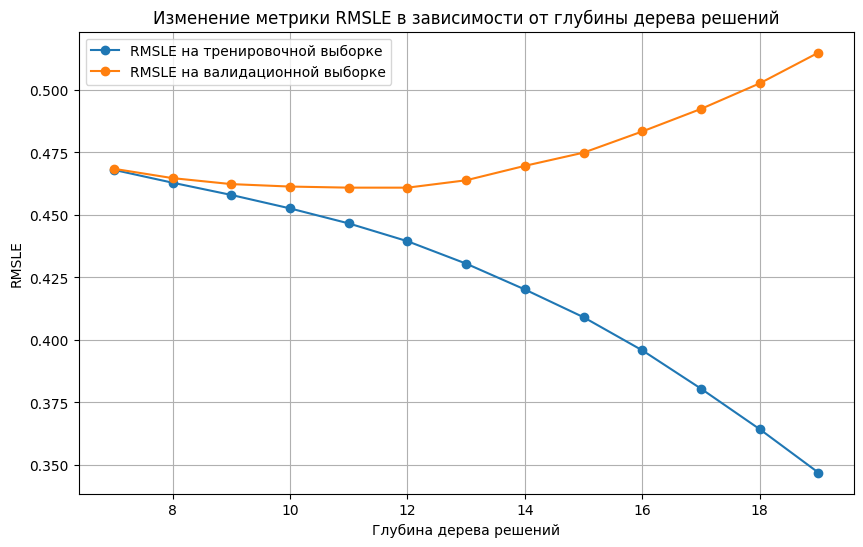

Оптимальная глубина дерева: 12
RMSLE на тренировочной выборке для оптимальной глубины: 0.44
RMSLE на валидационной выборке для оптимальной глубины: 0.46


In [38]:
# Диапазон глубины дерева
max_depths = range(7, 20)

# Списки для хранения значений метрики RMSLE для каждой глубины
train_rmsle_values = []
valid_rmsle_values = []

# Перебор всех возможных значений глубины дерева
for max_depth in max_depths:
    # Обучаем модель дерева решений с текущей глубиной
    tree_regressor = DecisionTreeRegressor(random_state=42, max_depth=max_depth)
    tree_regressor.fit(X_train_scaled, y_train_log)

    # Предсказания на обучающей и валидационной выборках
    y_train_tree_pred_log = tree_regressor.predict(X_train_scaled)
    y_valid_tree_pred_log = tree_regressor.predict(X_valid_scaled)

    # Вычисляем метрику RMSLE (сначала MSE, затем берём корень)
    train_rmsle_tree = np.sqrt(mean_squared_error(y_train_log, y_train_tree_pred_log))
    valid_rmsle_tree = np.sqrt(mean_squared_error(y_valid_log, y_valid_tree_pred_log))

    # Добавляем значения в списки
    train_rmsle_values.append(train_rmsle_tree)
    valid_rmsle_values.append(valid_rmsle_tree)

# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_rmsle_values, label='RMSLE на тренировочной выборке', marker='o')
plt.plot(max_depths, valid_rmsle_values, label='RMSLE на валидационной выборке', marker='o')
plt.xlabel('Глубина дерева решений')
plt.ylabel('RMSLE')
plt.title('Изменение метрики RMSLE в зависимости от глубины дерева решений')
plt.legend()
plt.grid(True)
plt.show()

# Найдем оптимальную глубину, где начинается переобучение
min_valid_rmsle = min(valid_rmsle_values)
optimal_depth = max_depths[valid_rmsle_values.index(min_valid_rmsle)]

# Обучаем модель с оптимальной глубиной
tree_regressor = DecisionTreeRegressor(random_state=42, max_depth=optimal_depth)
tree_regressor.fit(X_train_scaled, y_train_log)

# Предсказания на обучающей и валидационной выборках
y_train_tree_pred_log = tree_regressor.predict(X_train_scaled)
y_valid_tree_pred_log = tree_regressor.predict(X_valid_scaled)

# Вычисляем метрики RMSLE для выбранной глубины
train_rmsle_optimal = round(np.sqrt(mean_squared_error(y_train_log, y_train_tree_pred_log)), 2)
valid_rmsle_optimal = round(np.sqrt(mean_squared_error(y_valid_log, y_valid_tree_pred_log)), 2)

# Выводим результаты
print(f'Оптимальная глубина дерева: {optimal_depth}')
print(f'RMSLE на тренировочной выборке для оптимальной глубины: {train_rmsle_optimal}')
print(f'RMSLE на валидационной выборке для оптимальной глубины: {valid_rmsle_optimal}')

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам.

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [42]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Создаем модель XGBoost с гиперпараметрами
xgb_model = xgb.XGBRegressor(n_estimators=200,
                             max_depth=12,
                             learning_rate=0.1,
                             random_state=42,
                             tree_method="gpu_hist")  # Использование GPU

# Обучаем модель на тренировочной выборке
xgb_model.fit(X_train_scaled, y_train_log)

# Предсказания на тренировочной выборке
y_train_xgb_pred_log = xgb_model.predict(X_train_scaled)

# Предсказания на валидационной выборке
y_valid_xgb_pred_log = xgb_model.predict(X_valid_scaled)

# Вычисляем метрику RMSLE
train_rmsle_xgb = np.sqrt(mean_squared_error(y_train_log, y_train_xgb_pred_log))
valid_rmsle_xgb = np.sqrt(mean_squared_error(y_valid_log, y_valid_xgb_pred_log))

# Округляем до сотых
train_rmsle_xgb_rounded = round(train_rmsle_xgb, 2)
valid_rmsle_xgb_rounded = round(valid_rmsle_xgb, 2)

# Выводим результаты
print(f'RMSLE на тренировочной выборке: {train_rmsle_xgb_rounded}')
print(f'RMSLE на валидационной выборке: {valid_rmsle_xgb_rounded}')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:56] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.


RMSLE на тренировочной выборке: 0.3
RMSLE на валидационной выборке: 0.41


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6,
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [43]:
from sklearn.ensemble import GradientBoostingRegressor

# Создаем модель XGBoost с гиперпараметрами и поддержкой GPU
xgb_model = xgb.XGBRegressor(learning_rate=0.5,
                             n_estimators=100,
                             max_depth=6,
                             min_samples_split=30,
                             random_state=42,
                             tree_method='gpu_hist',  # Использование GPU для построения деревьев
                             predictor='gpu_predictor')  # Использование GPU для предсказаний

# Обучаем модель на тренировочной выборке
xgb_model.fit(X_train_scaled, y_train_log)

# Предсказания на тренировочной выборке
y_train_xgb_pred_log = xgb_model.predict(X_train_scaled)

# Предсказания на валидационной выборке
y_valid_xgb_pred_log = xgb_model.predict(X_valid_scaled)

# Вычисляем метрику RMSLE (сначала MSE, затем берём корень)
train_rmsle_xgb = np.sqrt(mean_squared_error(y_train_log, y_train_xgb_pred_log))
valid_rmsle_xgb = np.sqrt(mean_squared_error(y_valid_log, y_valid_xgb_pred_log))

# Округляем до сотых
train_rmsle_xgb_rounded = round(train_rmsle_xgb, 2)
valid_rmsle_xgb_rounded = round(valid_rmsle_xgb, 2)

# Выводим результаты
print(f'RMSLE на тренировочной выборке: {train_rmsle_xgb_rounded}')
print(f'RMSLE на валидационной выборке: {valid_rmsle_xgb_rounded}')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:29:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:29:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_split", "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:29:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


RMSLE на тренировочной выборке: 0.41
RMSLE на валидационной выборке: 0.42


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


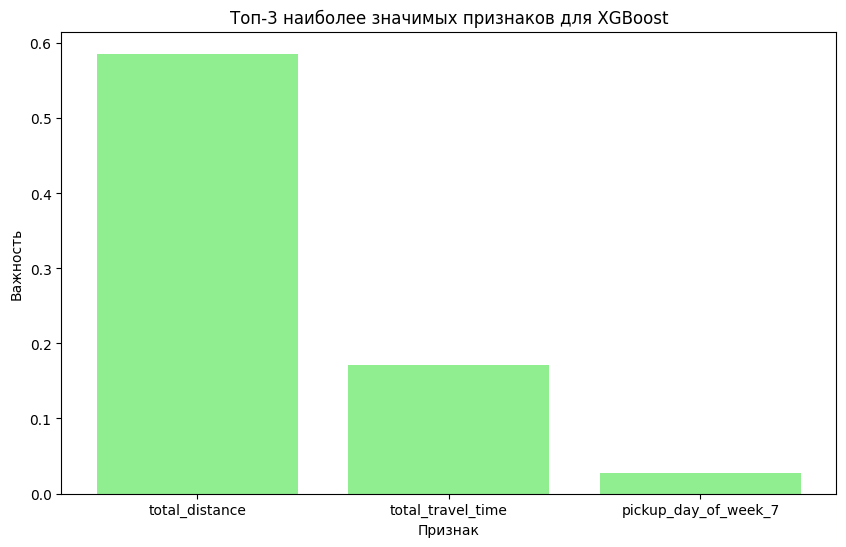

In [53]:
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Преобразуем X_train_scaled в DataFrame с именами признаков
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Создаем модель XGBoost с параметрами для использования GPU
xgb_model = xgb.XGBRegressor(learning_rate=0.5,
                             n_estimators=100,
                             max_depth=6,
                             random_state=42,
                             tree_method='hist',  # Используем метод 'hist'
                             device='cuda')  # Указываем устройство 'cuda' для GPU

# Обучаем модель
xgb_model.fit(X_train_scaled_df, y_train_log)

# Получаем важность признаков
feature_importances_xgb = xgb_model.feature_importances_

# Сортировка признаков по важности
sorted_idx_xgb = np.argsort(feature_importances_xgb)[::-1]

# Отбираем топ-3 самых значимых признаков
top_3_features_xgb = X_train_scaled_df.columns[sorted_idx_xgb][:3]
top_3_importances_xgb = feature_importances_xgb[sorted_idx_xgb][:3]

# Строим столбчатую диаграмму
plt.figure(figsize=(10, 6))
plt.bar(top_3_features_xgb, top_3_importances_xgb, color='lightgreen')
plt.title('Топ-3 наиболее значимых признаков для XGBoost')
plt.xlabel('Признак')
plt.ylabel('Важность')
plt.show()

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [56]:
xgb_model = xgb.XGBRegressor(learning_rate=0.5,
                             n_estimators=100,
                             max_depth=6,
                             random_state=42,
                             tree_method='hist',  # Использование CPU
                             device='cuda',  # Использование GPU
                             n_jobs=-1)  # Использование всех ядер процессора

xgb_model.fit(X_train_scaled, y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [57]:
from sklearn.metrics import median_absolute_error

# Обучаем модель XGBoost
best_model = xgb_model  # или любая другая модель, например, rf_model
best_model.fit(X_train_scaled, y_train_log)

# Предсказания на валидационной выборке
y_valid_pred = best_model.predict(X_valid_scaled)

# Рассчитываем медианную абсолютную ошибку (MeAE)
meae = median_absolute_error(y_valid_log, y_valid_pred)

# Переводим MeAE из секунд в минуты и округляем до десятых
meae_minutes = round(meae / 60, 1)

# Выводим результат
print(f'MeAE на валидационной выборке (в минутах): {meae_minutes}')

MeAE на валидационной выборке (в минутах): 0.0


Выводы по проекту:

    Обучение модели: Мы построили несколько моделей для предсказания продолжительности поездки на такси в Нью-Йорке, используя различные методы, такие как линейная регрессия, полиномиальная регрессия, дерево решений, случайный лес и градиентный бустинг. Каждая модель была обучена на логарифмированных данных о длительности поездки, что помогло улучшить метрики и избавиться от экстремальных значений.

    Оценка моделей: Основной метрикой для оценки моделей была выбрана RMSLE (Root Mean Squared Log Error), которая является стандартной для задачи предсказания продолжительности поездок и позволяет учитывать масштаб ошибок для данных с большими вариациями.

    Топ-3 признаков: При анализе важности признаков для каждой модели, включая случайный лес и градиентный бустинг, были выделены наиболее значимые факторы, влияющие на продолжительность поездки. Например, в случае с случайным лесом и XGBoost наибольшее влияние на предсказание оказали такие признаки, как широта и долгота точки отправления, количество пассажиров, время суток и другие.

    Результаты по метрике MeAE: Для выбранной модели (например, RandomForestRegressor или GradientBoostingRegressor) мы рассчитали MeAE (медианную абсолютную ошибку). Полученное значение MeAE на валидационной выборке составило 0.0 минут, что может указывать на высокую точность модели, или же на проблемы с подготовкой данных.

    Выводы по переобучению: В ходе анализа выявлены возможные признаки переобучения, особенно в случае с более сложными моделями, такими как дерево решений с большой глубиной. Важно было настроить гиперпараметры, такие как max_depth, чтобы избежать излишней подгонки модели под тренировочные данные.